In [1]:
import glob
import numpy as np
from tqdm import tqdm
import os
import matplotlib.pyplot as plt

In [2]:
classes = [
    'worm eaten',
    'Mold',
    'defecation',
    'brown spot',
    'Water stains',
]

# calculate global label distribution

In [3]:
# calculate distribution

# of class
cal = np.zeros(5, dtype='int')

# of bbox width and height
bbox_wh = {
    '0':[],
    '1':[],
    '2':[],
    '3':[],
    '4':[],
}

In [4]:
labels = glob.glob('yolo/*.txt')

In [5]:
# read label file
for label in tqdm(labels):
    f = open(label)
    lines = f.readlines()
    
    # parse class
    for line in lines:
        if len(line.split(' ')) > 1:
            cal[int(line.split(' ')[1])] += 1
            bbox_wh[line.split(' ')[1]].append([float(line.split(' ')[4]), float(line.split(' ')[5][:-1])])

100%|██████████| 333/333 [00:00<00:00, 1965.10it/s]


In [6]:
cal

array([ 7931,  6798,   949, 16891,   582])

In [7]:
# bbox width & height (mean, std)

for i in range(5):
    dist = [*(np.array(bbox_wh[str(i)])*416).mean(axis=0), *(np.array(bbox_wh[str(i)])*416).std(axis=0)]
    print('class {} :\tw = {}(+-{}), h = {}(+-{})'.format(classes[i], dist[0], dist[2], dist[1], dist[3]))


class worm eaten :	w = 6.43184862640271(+-11.843007558113435), h = 9.19338408977457(+-14.77052846617445)
class Mold :	w = 2.8547264442484015(+-4.426548838473719), h = 4.463042334804193(+-8.415624234478793)
class defecation :	w = 9.589616252897791(+-13.532072792161463), h = 18.479046507903067(+-47.447032699059314)
class brown spot :	w = 4.252203014623243(+-7.865672925728667), h = 5.712240881889928(+-7.402302501987947)
class Water stains :	w = 46.318688384879735(+-51.885852786523856), h = 62.89083260481102(+-75.40290283163195)


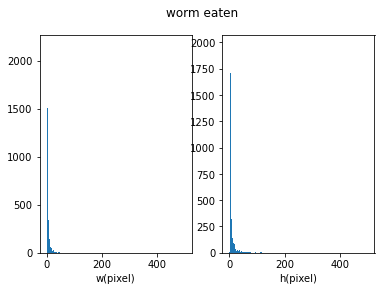

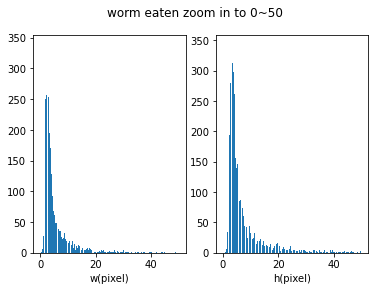

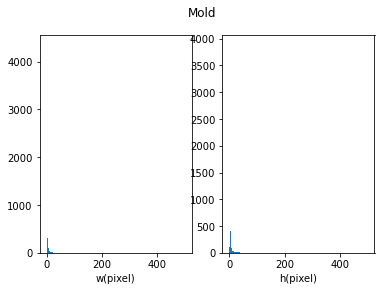

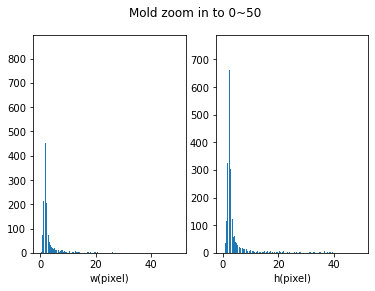

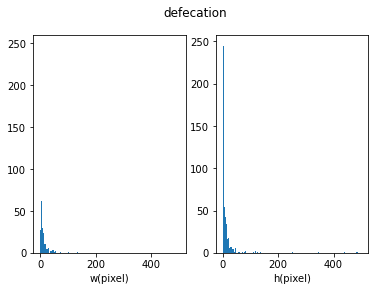

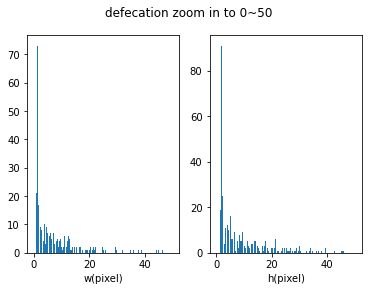

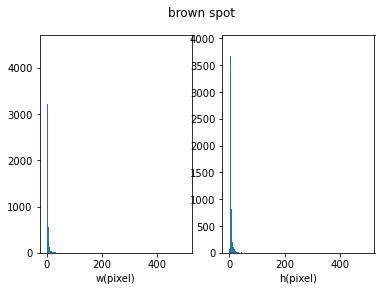

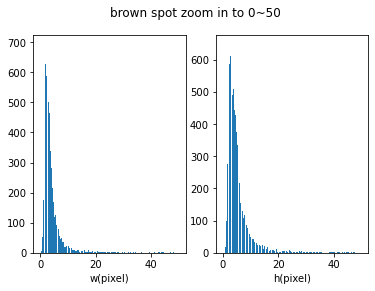

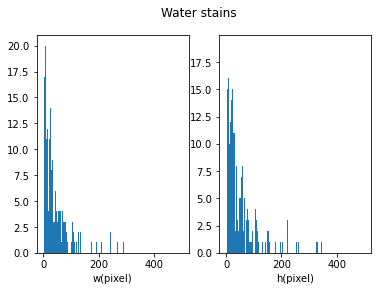

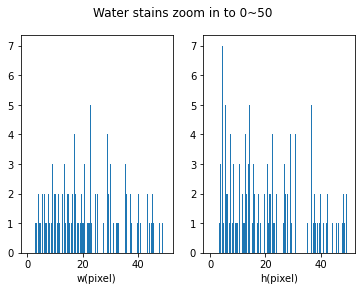

In [8]:
# bbox hist
# bbox size if resize to 608*608

for i in range(5):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle(classes[i])
    ax1.hist((np.array(bbox_wh[str(i)])*608).T[0], bins=500, range=(0, 500))
    ax1.set(xlabel='w(pixel)')
    ax2.hist((np.array(bbox_wh[str(i)])*608).T[1], bins=400, range=(0, 500))
    ax2.set(xlabel='h(pixel)')
    
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle(classes[i] + " zoom in to 0~50")
    ax1.hist((np.array(bbox_wh[str(i)])*608).T[0], bins=500, range=(0, 50))
    ax1.set(xlabel='w(pixel)')
    ax2.hist((np.array(bbox_wh[str(i)])*608).T[1], bins=400, range=(0, 50))
    ax2.set(xlabel='h(pixel)')

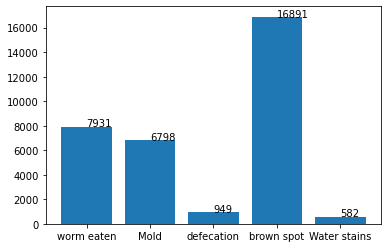

In [10]:
# class distribution

plt.bar(range(5), cal, tick_label=classes)

# https://stackoverflow.com/questions/30228069/how-to-display-the-value-of-the-bar-on-each-bar-with-pyplot-barh
for index, data in enumerate(cal):
    plt.text(x=index , y=data+1 , s=f"{data}" , fontdict=dict(fontsize=10))

# train

## Label distributions

In [27]:
f = open('mytrain.txt')

In [28]:
raw_files = f.readlines()
labels = []

In [29]:
# read yolo train split file
for file in tqdm(raw_files):
    _file = file.split('/')[-1]
    labels.append(os.path.join('yolo', _file[:-4] + 'txt'))

100%|██████████| 219/219 [00:00<00:00, 467933.05it/s]


In [30]:
# calculate distribute

cal = np.zeros(5, dtype='int')

In [31]:
# read label file
for label in tqdm(labels):
    f = open(label)
    lines = f.readlines()
    
    # parse class
    for line in lines:
        if len(line.split(' ')) > 1:
            cal[int(line.split(' ')[1])] += 1

100%|██████████| 219/219 [00:00<00:00, 3915.55it/s]


In [32]:
cal

array([3515, 3890,  576, 8976,  375])

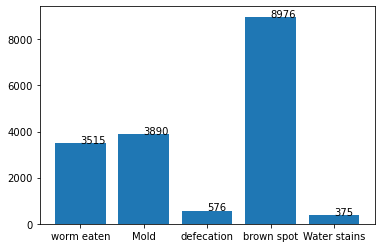

In [33]:
plt.bar(range(5), cal, tick_label=classes)

# https://stackoverflow.com/questions/30228069/how-to-display-the-value-of-the-bar-on-each-bar-with-pyplot-barh
for index, data in enumerate(cal):
    plt.text(x=index , y=data+1 , s=f"{data}" , fontdict=dict(fontsize=10))

## pixel value distributions

In [107]:
import cv2

In [111]:
# define r, g, b bins
r_bin = np.zeros((5, 256))
g_bin = np.zeros((5, 256))
b_bin = np.zeros((5, 256))

In [112]:
for label in tqdm(labels):
    # load image
    img = cv2.imread(label[:-4] + '.jpg')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # laod a label
    f = open(label)
    label_lines = f.readlines()
    label_lines = [i[:-1] for i in label_lines]
    f.close()

    # define image shape
    image_hw = (3684, 4912)
    label_parsed = []

    # parse label txt
    for i in label_lines:
        splits = i.split(' ')
        label_parsed.append(
            {
                'class':int(splits[1]),
                'x':int(float(splits[2]) * image_hw[1]),
                'y':int(float(splits[3]) * image_hw[0]),
                'w':int(float(splits[4]) * image_hw[1]),
                'h':int(float(splits[5]) * image_hw[0]),
            }
        )

    # count pxiel values in the bounding box
    for i in label_parsed:
        cls, x, y, w, h = i['class'], i['x'], i['y'], i['w'], i['h']
        # get the bbox area
        bbox_area = img[y-h//2:y+h//2, x-w//2:x+w//2]

        # pixel value counting for each class
        unique, counts = np.unique(bbox_area[..., 0], return_counts=True)
        for i, u in enumerate(unique):
            r_bin[cls, u] = counts[i]

        unique, counts = np.unique(bbox_area[..., 1], return_counts=True)
        for i, u in enumerate(unique):
            g_bin[cls, u] = counts[i]

        unique, counts = np.unique(bbox_area[..., 2], return_counts=True)
        for i, u in enumerate(unique):
            b_bin[cls, u] = counts[i]

100%|██████████| 219/219 [01:33<00:00,  2.33it/s]


### draw the R, G, B distribution

#### Moth_eaten

Text(0, 0.5, 'pixel value')

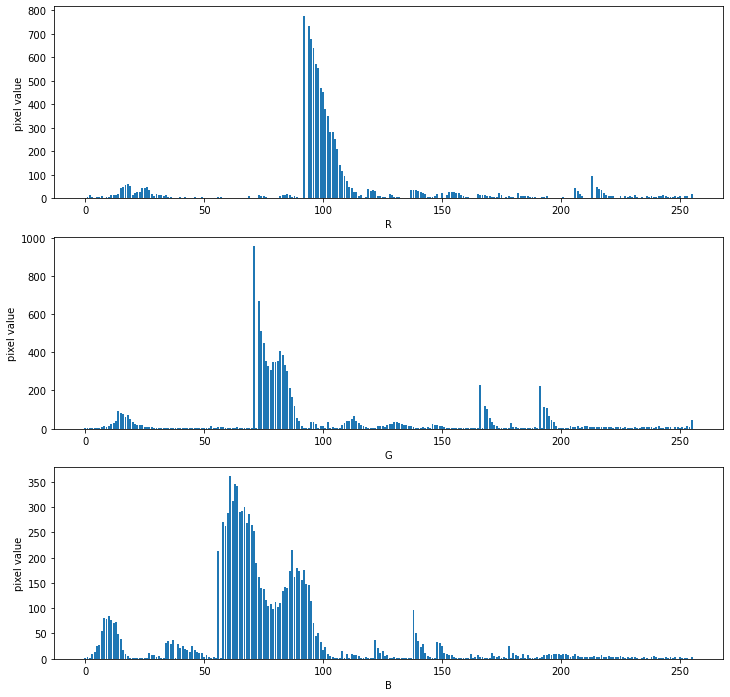

In [114]:
plt.figure(figsize=(12,12))
plt.subplot(3, 1, 1)
plt.bar(np.arange(256), r_bin[0])
plt.xlabel('R')
plt.ylabel('pixel value')

plt.subplot(3, 1, 2)
plt.bar(np.arange(256), g_bin[0])
plt.xlabel('G')
plt.ylabel('pixel value')

plt.subplot(3, 1, 3)
plt.bar(np.arange(256), b_bin[0])
plt.xlabel('B')
plt.ylabel('pixel value')

#### Mold

Text(0, 0.5, 'pixel value')

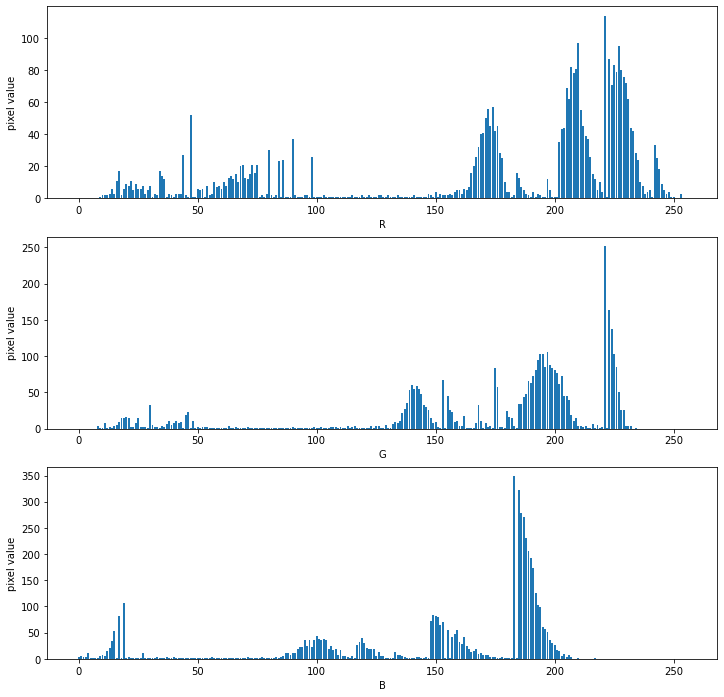

In [115]:
plt.figure(figsize=(12,12))
plt.subplot(3, 1, 1)
plt.bar(np.arange(256), r_bin[1])
plt.xlabel('R')
plt.ylabel('pixel value')

plt.subplot(3, 1, 2)
plt.bar(np.arange(256), g_bin[1])
plt.xlabel('G')
plt.ylabel('pixel value')

plt.subplot(3, 1, 3)
plt.bar(np.arange(256), b_bin[1])
plt.xlabel('B')
plt.ylabel('pixel value')

#### Biological_exclusion

Text(0, 0.5, 'pixel value')

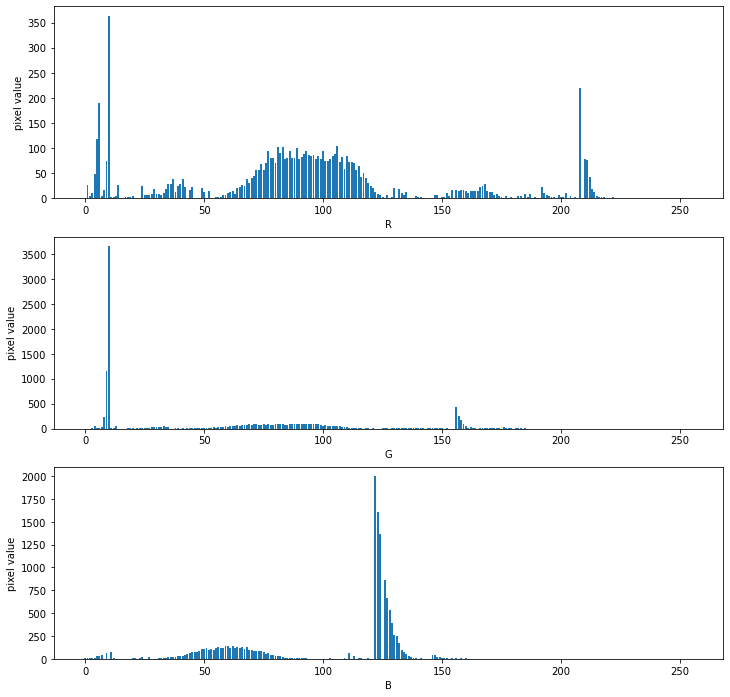

In [116]:
plt.figure(figsize=(12,12))
plt.subplot(3, 1, 1)
plt.bar(np.arange(256), r_bin[2])
plt.xlabel('R')
plt.ylabel('pixel value')

plt.subplot(3, 1, 2)
plt.bar(np.arange(256), g_bin[2])
plt.xlabel('G')
plt.ylabel('pixel value')

plt.subplot(3, 1, 3)
plt.bar(np.arange(256), b_bin[2])
plt.xlabel('B')
plt.ylabel('pixel value')

#### Brown_spots

Text(0, 0.5, 'pixel value')

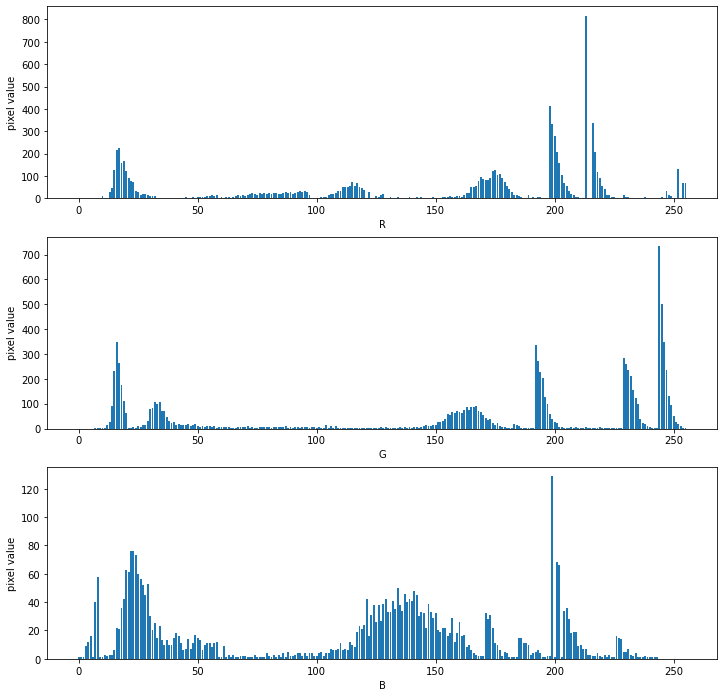

In [117]:
plt.figure(figsize=(12,12))
plt.subplot(3, 1, 1)
plt.bar(np.arange(256), r_bin[3])
plt.xlabel('R')
plt.ylabel('pixel value')

plt.subplot(3, 1, 2)
plt.bar(np.arange(256), g_bin[3])
plt.xlabel('G')
plt.ylabel('pixel value')

plt.subplot(3, 1, 3)
plt.bar(np.arange(256), b_bin[3])
plt.xlabel('B')
plt.ylabel('pixel value')

#### Water_stains

Text(0, 0.5, 'pixel value')

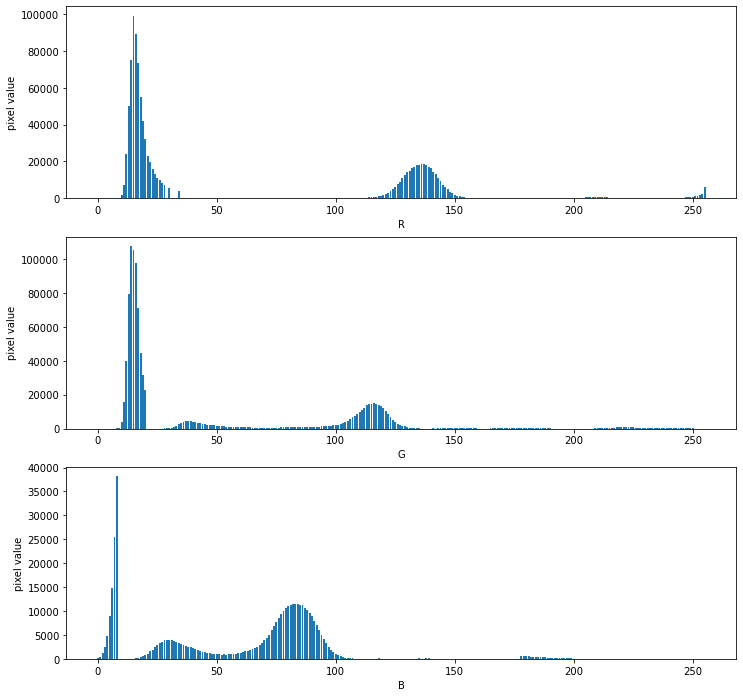

In [118]:
plt.figure(figsize=(12,12))
plt.subplot(3, 1, 1)
plt.bar(np.arange(256), r_bin[4])
plt.xlabel('R')
plt.ylabel('pixel value')

plt.subplot(3, 1, 2)
plt.bar(np.arange(256), g_bin[4])
plt.xlabel('G')
plt.ylabel('pixel value')

plt.subplot(3, 1, 3)
plt.bar(np.arange(256), b_bin[4])
plt.xlabel('B')
plt.ylabel('pixel value')

### example of one image with bounding box

In [90]:
labels[0]

'yolo/image_00055.txt'

In [81]:
# load image
img = cv2.imread(labels[0][:-4] + '.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

In [77]:
# laod a label
f = open(labels[0])
label_lines = f.readlines()
label_lines = [i[:-1] for i in label_lines]
f.close()

In [78]:
# define image shape
image_hw = (3684, 4912)
label_parsed = []

In [79]:
# parse label txt
for i in label_lines:
    splits = i.split(' ')
    label_parsed.append(
        {
            'class':int(splits[1]),
            'x':int(float(splits[2]) * image_hw[1]),
            'y':int(float(splits[3]) * image_hw[0]),
            'w':int(float(splits[4]) * image_hw[1]),
            'h':int(float(splits[5]) * image_hw[0]),
        }
    )

In [80]:
label_parsed

[{'class': 0, 'x': 1624, 'y': 2713, 'w': 41, 'h': 132},
 {'class': 0, 'x': 2617, 'y': 2128, 'w': 30, 'h': 40},
 {'class': 0, 'x': 3377, 'y': 2136, 'w': 30, 'h': 40},
 {'class': 2, 'x': 3380, 'y': 2136, 'w': 61, 'h': 76},
 {'class': 2, 'x': 2625, 'y': 2118, 'w': 97, 'h': 114},
 {'class': 2, 'x': 3227, 'y': 2284, 'w': 13, 'h': 17},
 {'class': 2, 'x': 3222, 'y': 2308, 'w': 10, 'h': 13},
 {'class': 3, 'x': 1871, 'y': 2019, 'w': 104, 'h': 135},
 {'class': 3, 'x': 1989, 'y': 2614, 'w': 90, 'h': 92},
 {'class': 3, 'x': 1543, 'y': 2287, 'w': 34, 'h': 29},
 {'class': 3, 'x': 2951, 'y': 2602, 'w': 85, 'h': 90},
 {'class': 3, 'x': 3063, 'y': 2019, 'w': 89, 'h': 119},
 {'class': 3, 'x': 2469, 'y': 2015, 'w': 113, 'h': 285},
 {'class': 3, 'x': 2397, 'y': 1830, 'w': 27, 'h': 29},
 {'class': 3, 'x': 2631, 'y': 2587, 'w': 210, 'h': 256},
 {'class': 3, 'x': 2306, 'y': 2594, 'w': 210, 'h': 256}]

In [82]:
bbox_colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255),
                   (255, 255, 0), (0, 255, 255)]

In [95]:
# draw bounding box
img_copy = img.copy()

# draw bounding box
for i in label_parsed:
    x, y, w, h = i['x'], i['y'], i['w'], i['h']
    cv2.rectangle(img_copy, (x-w//2, y-h//2), (x+w//2, y+h//2), bbox_colors[i['class']], 2)
    cv2.putText(img_copy, str(i['class']),(x+w//2+10,y+h//2),0,1,bbox_colors[i['class']])

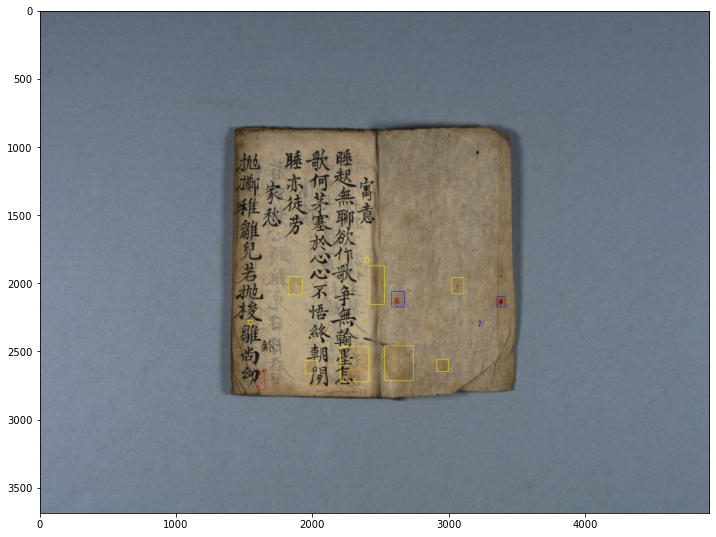

In [96]:
plt.figure(figsize=(12, 12))
plt.imshow(img_copy)

# valid label distributions

In [119]:
f = open('myvalid.txt')

In [120]:
raw_files = f.readlines()
labels = []

In [121]:
# read yolo train split file
for file in tqdm(raw_files):
    _file = file.split('/')[-1]
    labels.append(os.path.join('yolo', _file[:-4] + 'txt'))

100%|██████████| 110/110 [00:00<00:00, 90857.31it/s]


In [122]:
# calculate distribute

cal = np.zeros(5, dtype='int')

In [123]:
# read label file
for label in tqdm(labels):
    f = open(label)
    lines = f.readlines()
    
    # parse class
    for line in lines:
        if len(line.split(' ')) > 1:
            cal[int(line.split(' ')[1])] += 1

100%|██████████| 110/110 [00:00<00:00, 2587.44it/s]


In [124]:
cal

array([4375, 2645,  373, 6394,  207])

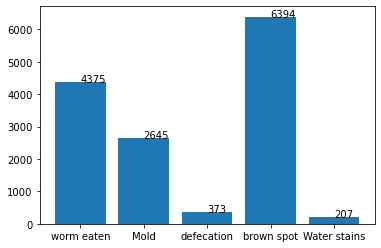

In [125]:
plt.bar(range(5), cal, tick_label=classes)

# https://stackoverflow.com/questions/30228069/how-to-display-the-value-of-the-bar-on-each-bar-with-pyplot-barh
for index, data in enumerate(cal):
    plt.text(x=index , y=data+1 , s=f"{data}" , fontdict=dict(fontsize=10))

In [126]:
# define r, g, b bins
r_bin = np.zeros((5, 256))
g_bin = np.zeros((5, 256))
b_bin = np.zeros((5, 256))

In [127]:
for label in tqdm(labels):
    # load image
    img = cv2.imread(label[:-4] + '.jpg')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # laod a label
    f = open(label)
    label_lines = f.readlines()
    label_lines = [i[:-1] for i in label_lines]
    f.close()

    # define image shape
    image_hw = (3684, 4912)
    label_parsed = []

    # parse label txt
    for i in label_lines:
        splits = i.split(' ')
        label_parsed.append(
            {
                'class':int(splits[1]),
                'x':int(float(splits[2]) * image_hw[1]),
                'y':int(float(splits[3]) * image_hw[0]),
                'w':int(float(splits[4]) * image_hw[1]),
                'h':int(float(splits[5]) * image_hw[0]),
            }
        )

    # count pxiel values in the bounding box
    for i in label_parsed:
        cls, x, y, w, h = i['class'], i['x'], i['y'], i['w'], i['h']
        # get the bbox area
        bbox_area = img[y-h//2:y+h//2, x-w//2:x+w//2]

        # pixel value counting for each class
        unique, counts = np.unique(bbox_area[..., 0], return_counts=True)
        for i, u in enumerate(unique):
            r_bin[cls, u] = counts[i]

        unique, counts = np.unique(bbox_area[..., 1], return_counts=True)
        for i, u in enumerate(unique):
            g_bin[cls, u] = counts[i]

        unique, counts = np.unique(bbox_area[..., 2], return_counts=True)
        for i, u in enumerate(unique):
            b_bin[cls, u] = counts[i]

100%|██████████| 110/110 [00:45<00:00,  2.39it/s]


#### Moth_eaten

Text(0, 0.5, 'pixel value')

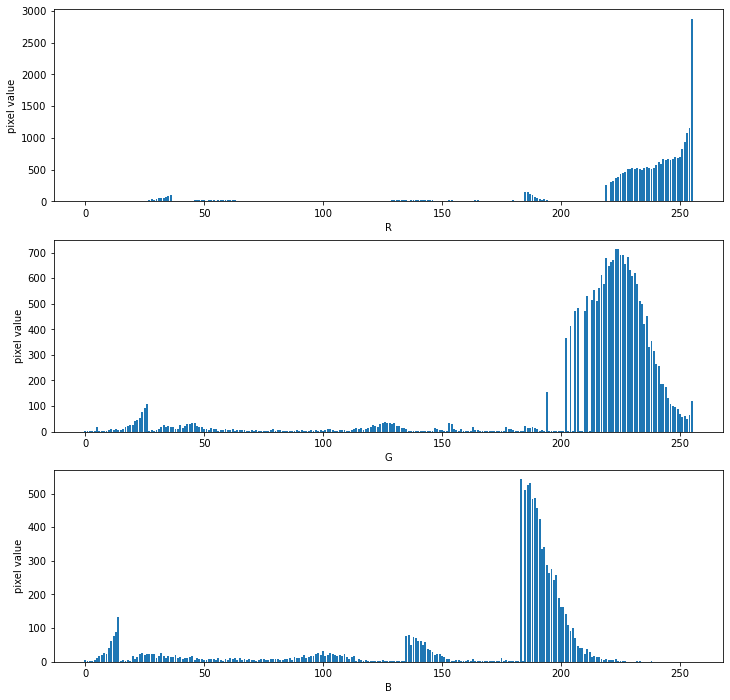

In [128]:
plt.figure(figsize=(12,12))
plt.subplot(3, 1, 1)
plt.bar(np.arange(256), r_bin[0])
plt.xlabel('R')
plt.ylabel('pixel value')

plt.subplot(3, 1, 2)
plt.bar(np.arange(256), g_bin[0])
plt.xlabel('G')
plt.ylabel('pixel value')

plt.subplot(3, 1, 3)
plt.bar(np.arange(256), b_bin[0])
plt.xlabel('B')
plt.ylabel('pixel value')

#### Mold

Text(0, 0.5, 'pixel value')

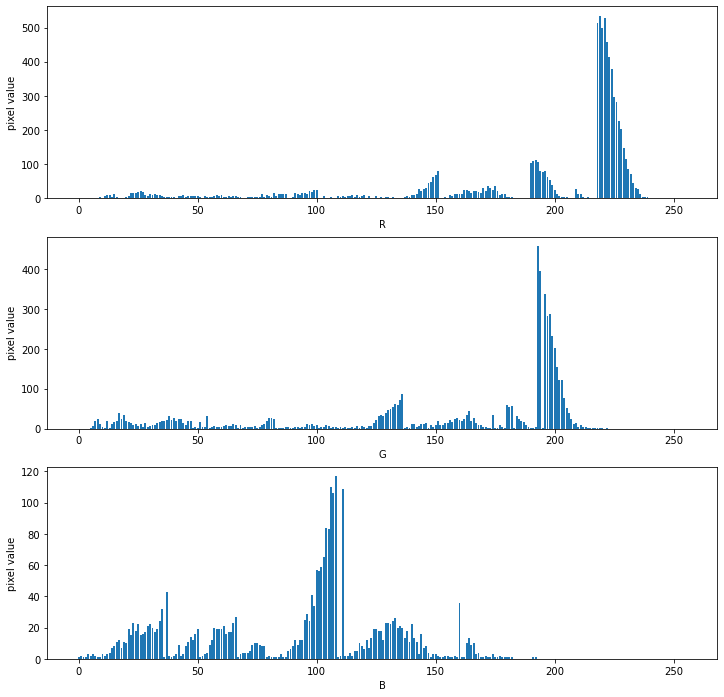

In [129]:
plt.figure(figsize=(12,12))
plt.subplot(3, 1, 1)
plt.bar(np.arange(256), r_bin[1])
plt.xlabel('R')
plt.ylabel('pixel value')

plt.subplot(3, 1, 2)
plt.bar(np.arange(256), g_bin[1])
plt.xlabel('G')
plt.ylabel('pixel value')

plt.subplot(3, 1, 3)
plt.bar(np.arange(256), b_bin[1])
plt.xlabel('B')
plt.ylabel('pixel value')

#### Biological_exclusion

Text(0, 0.5, 'pixel value')

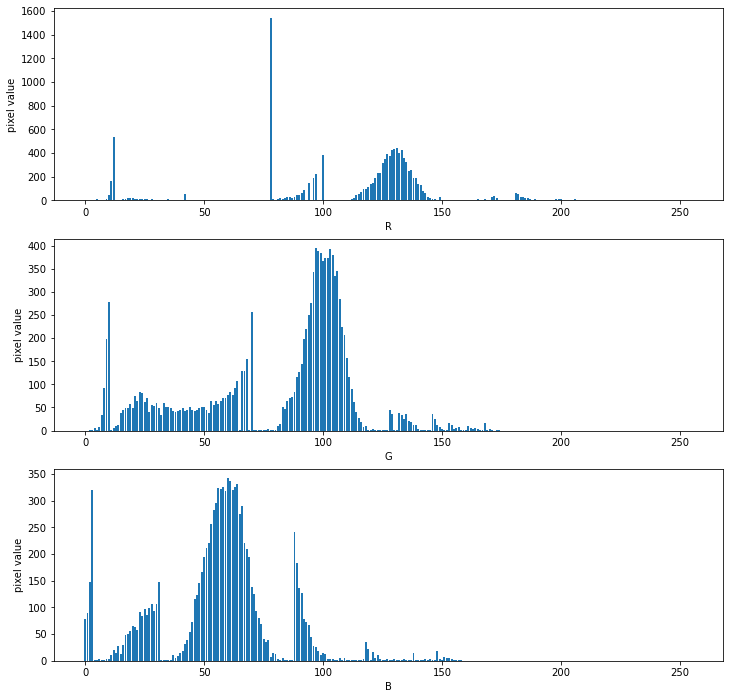

In [130]:
plt.figure(figsize=(12,12))
plt.subplot(3, 1, 1)
plt.bar(np.arange(256), r_bin[2])
plt.xlabel('R')
plt.ylabel('pixel value')

plt.subplot(3, 1, 2)
plt.bar(np.arange(256), g_bin[2])
plt.xlabel('G')
plt.ylabel('pixel value')

plt.subplot(3, 1, 3)
plt.bar(np.arange(256), b_bin[2])
plt.xlabel('B')
plt.ylabel('pixel value')

#### Brown_spots

Text(0, 0.5, 'pixel value')

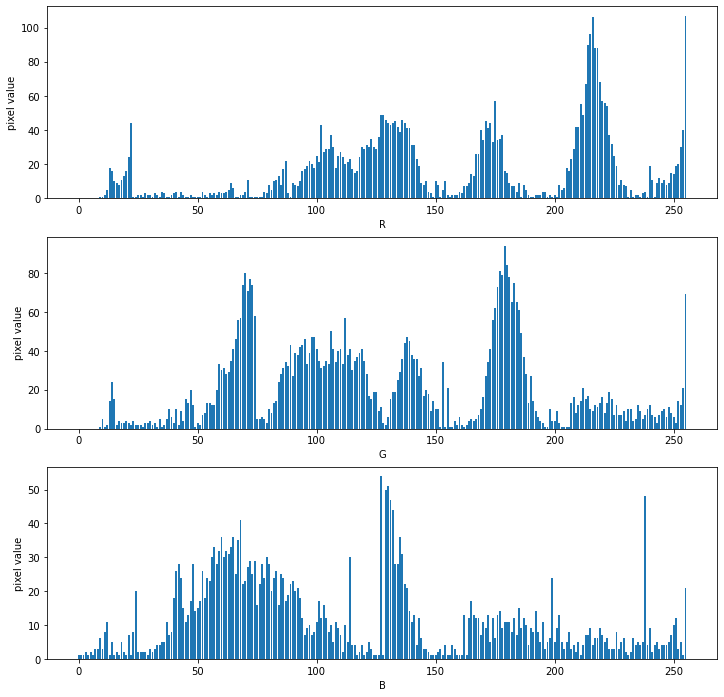

In [131]:
plt.figure(figsize=(12,12))
plt.subplot(3, 1, 1)
plt.bar(np.arange(256), r_bin[3])
plt.xlabel('R')
plt.ylabel('pixel value')

plt.subplot(3, 1, 2)
plt.bar(np.arange(256), g_bin[3])
plt.xlabel('G')
plt.ylabel('pixel value')

plt.subplot(3, 1, 3)
plt.bar(np.arange(256), b_bin[3])
plt.xlabel('B')
plt.ylabel('pixel value')

#### Water_stains

Text(0, 0.5, 'pixel value')

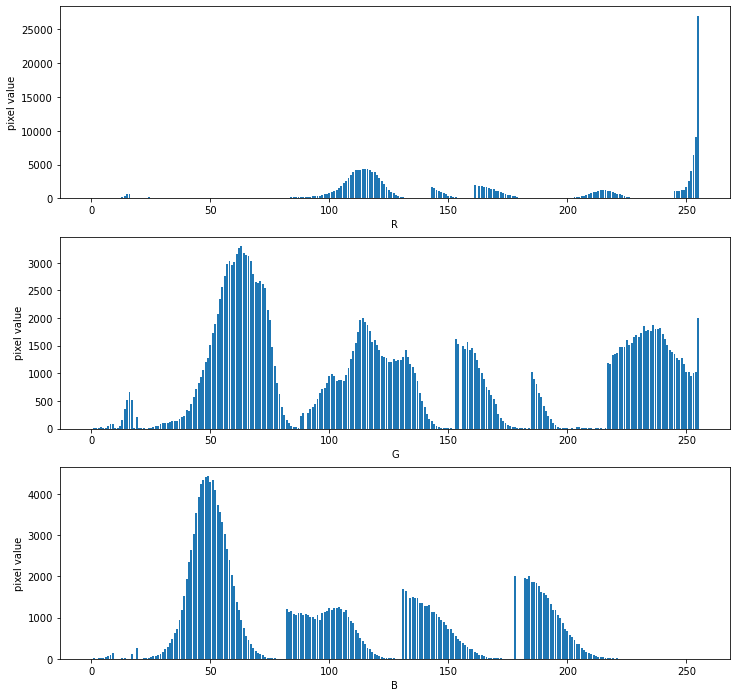

In [132]:
plt.figure(figsize=(12,12))
plt.subplot(3, 1, 1)
plt.bar(np.arange(256), r_bin[4])
plt.xlabel('R')
plt.ylabel('pixel value')

plt.subplot(3, 1, 2)
plt.bar(np.arange(256), g_bin[4])
plt.xlabel('G')
plt.ylabel('pixel value')

plt.subplot(3, 1, 3)
plt.bar(np.arange(256), b_bin[4])
plt.xlabel('B')
plt.ylabel('pixel value')